In [33]:
# import necessary libraries
import pandas as pd
import numpy as np
import csv
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from statsmodels.iolib.summary2 import summary_col

# define style 
plt.style.use('bmh')
plt.rcParams["font.family"] = "helvetica"

# expand pd display for debugging
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# define functions
# function for leave-one-out cross validation
def loso_cv(session_id, data, y_test_arr, y_pred_arr):
    # get unique session_id (which represent one unique subject) & split data into two parts: data from that subject
    # and data from everyone else
    LOOCV_O = session_id
    data_filtered = data[data['session_id'] != LOOCV_O]
    data_cv = data[data['session_id'] == LOOCV_O]
    
    # create test and train data
    X_test = data_cv.drop(columns=['selected', 'session_id'])
    y_test = data_cv['selected'] 
    X_train = data_filtered.drop(columns=['selected', 'session_id'])
    
    X_train = np.array(X_train)
    y_train = np.array(data_filtered['selected'])
    
    # fit logistic regression model
    res = sm.Logit(y_train.astype('float64'), X_train.astype('float64')).fit()
    print("training #", i, "completed")
                 
    # get predicted values   
    y_pred = res.predict(X_test)
    print("prediction completed")
    
    # add them to the ground truth values (y_test_arr) and predicted values (y_pred_arr) arrays 
    for x in y_test: 
        y_test_arr.append(x)
    for z in y_pred: 
        y_pred_arr.append(z)
                   
    return

# function to get unique session ids in the dataset
def unique(list1):
    unique_list = [] 
    for x in list1:
        if x not in unique_list:
            unique_list.append(x)
    return(unique_list)

# function to get profession category of each profession in the dataset
def get_profession_category(profession):
    all_professions = ['state governor','congress member', 'police officer', 'union leader','nurse', 'engineer', 'doctor', 'pharmacist', 'advertising practitioner', 'business executive', 'stockbroker', 'insurance salesperson', 'lawyer', 'journalist', 'university professor', 'clergy']
    gov_related = ['state governor','congress member', 'police officer', 'union leader'] # return 1 
    stem_related = ['nurse', 'engineer', 'doctor', 'pharmacist'] # return 2 
    business_related = ['advertising practitioner', 'business executive', 'stockbroker', 'insurance salesperson'] # return 3        
    other = ['lawyer', 'journalist', 'university professor', 'clergy'] # return 4
    
    # depending on which array a profession is in, return an integer value that represents that category
    if profession in gov_related:
        return(1)
    elif profession in stem_related:
        return(2)
    elif profession in business_related:
        return(3)
    elif profession in other:
        return(4)

# Prepare Conjoint Dataset

In [4]:
# read dataset with results into pd dataframe
results = pd.read_csv('datasets/results.csv')

In [5]:
# calculate in a variable whether the user completing this task deviated fromt the suggested advisor:
# made_changes = 0 -> no deviations, the suggested advisor attributes were reselected, made_changes = 1 ->
# at least one attribute was changed compared to the suggested advisor
results['made_changes'] = results['age_changed'] | results['gender_changed'] | results['race_changed'] | results['profession_changed']

In [6]:
# set up an empty dataframe to contain profiles of advisors that were 'selected'
dataset_conjoint_selected = pd.DataFrame(columns=['session_id', 'response_id', 'user_id', 'expense_category', 'expense', 'age','gender','race', 'profession', 'profession_category', 'selected', 'task_submit_time'])

In [7]:
# set up an empty dataframe to contain profiles of advisors that were 'not selected'
dataset_conjoint_not_selected = pd.DataFrame(columns=['session_id', 'response_id', 'user_id', 'expense_category', 'expense', 'age','gender','race', 'profession', 'profession_category', 'selected', 'task_submit_time'])

In [8]:
# populate the dataframe of selected advisor profiles, iterate through the results dataframe rows:
j = 0
for index, row in results.iterrows():
    # if a task did not involve making any changes and the suggested advisor attributes were reselected, 
    # then the suggested advisor attributes can be used to form a profile (consisting of an age, gender, race, 
    # and profession) that is considered preferable and thus 'selected'
    if(row['made_changes']==0):
        dataset_conjoint_selected.loc[index, 'session_id'] = row['session_id']
        dataset_conjoint_selected.loc[index, 'response_id'] = row['response_id']
        dataset_conjoint_selected.loc[index, 'user_id'] = row['user_id']
        dataset_conjoint_selected.loc[index, 'expense_category'] = row['expense_category']
        dataset_conjoint_selected.loc[index, 'expense'] = row['expense']
        dataset_conjoint_selected.loc[index, 'age'] = row['age_suggested']
        dataset_conjoint_selected.loc[index, 'gender'] = row['gender_suggested']
        dataset_conjoint_selected.loc[index, 'race'] = row['race_suggested']
        dataset_conjoint_selected.loc[index, 'profession'] = row['profession_suggested']
        dataset_conjoint_selected.loc[index, 'profession_category'] = get_profession_category(row['profession_suggested'])
        dataset_conjoint_selected.loc[index, 'selected'] = int(1)
        dataset_conjoint_selected.loc[index, 'task_submit_time'] = row['task_submit_time']
    # if a task *did* involve making at least one change to the suggested advisor attributes, 
    # then the newly selected advisor attributes can be used to form a profile (consisting of an age, gender, race, 
    # and profession) that is considered preferable and thus 'selected'
    else:
        dataset_conjoint_selected.loc[index, 'session_id'] = row['session_id']
        dataset_conjoint_selected.loc[index, 'response_id'] = row['response_id']
        dataset_conjoint_selected.loc[index, 'user_id'] = row['user_id']
        dataset_conjoint_selected.loc[index, 'expense_category'] = row['expense_category']
        dataset_conjoint_selected.loc[index, 'expense'] = row['expense']
        dataset_conjoint_selected.loc[index, 'age'] = row['age_selected']
        dataset_conjoint_selected.loc[index, 'gender'] = row['gender_selected']
        dataset_conjoint_selected.loc[index, 'race'] = row['race_selected']
        dataset_conjoint_selected.loc[index, 'profession'] = row['profession_selected']
        dataset_conjoint_selected.loc[index, 'profession_category'] = get_profession_category(row['profession_selected'])
        dataset_conjoint_selected.loc[index, 'selected'] = int(1)
        dataset_conjoint_selected.loc[index, 'task_submit_time'] = row['task_submit_time']
    j = j + 1

In [9]:
# populate the dataframe of not selected advisor profiles, iterate through the results dataframe rows and:
j = 0
for index, row in results.iterrows():
    # if a task *did* involve making at least one change to the suggested advisor attributes, 
    # then the newly selected advisor attributes were used to form a profile (consisting of a specific age, 
    # gender, race, and profession combination) that is considered preferable together and thus 'selected'. 
    # This implies that the presented suggested advisor profile (a different age, gender, race, and profession 
    # combination) was 'not selected'. This profile is added to the 'not selected' dataset
    if(row['made_changes']==1):
        dataset_conjoint_not_selected.loc[j, 'session_id'] = row['session_id']
        dataset_conjoint_not_selected.loc[j, 'response_id'] = row['response_id']
        dataset_conjoint_not_selected.loc[j, 'user_id'] = row['user_id']
        dataset_conjoint_not_selected.loc[j, 'expense_category'] = row['expense_category']
        dataset_conjoint_not_selected.loc[j, 'expense'] = row['expense']
        dataset_conjoint_not_selected.loc[j, 'age'] = row['age_suggested']
        dataset_conjoint_not_selected.loc[j, 'gender'] = row['gender_suggested']
        dataset_conjoint_not_selected.loc[j, 'race'] = row['race_suggested']
        dataset_conjoint_not_selected.loc[j, 'profession'] = row['profession_suggested']
        dataset_conjoint_not_selected.loc[j, 'profession_category'] = get_profession_category(row['profession_suggested'])
        dataset_conjoint_not_selected.loc[j, 'selected'] = int(0)
        dataset_conjoint_not_selected.loc[j, 'task_submit_time'] = row['task_submit_time']
    j = j + 1

In [10]:
# join the two datasets together. Profiles that are 'not selected' and those that are 'selected' differ by the value 
# of the 'selected' column in the dataset. 0 -> not selected, 1-> selected
dataset_conjoint = dataset_conjoint_selected.append(dataset_conjoint_not_selected)

In [11]:
# reset index & replace values for later analysis
dataset_conjoint = dataset_conjoint.reset_index(drop=True)
dataset_conjoint = dataset_conjoint.replace(['male', 'female', 'white', 'black', 'latino', 'asian'], [1, 2, 1, 2, 3, 4])

# Modelling & Analysis

In [12]:
# check that there are no null values
dataset_conjoint.isnull().sum()

session_id             0
response_id            0
user_id                0
expense_category       0
expense                0
age                    0
gender                 0
race                   0
profession             0
profession_category    0
selected               0
task_submit_time       0
dtype: int64

In [13]:
# create x and y values, y: selected column, x: age, gender, race, profession_category
y = dataset_conjoint['selected'].astype(float)
X = dataset_conjoint[['age', 'gender', 'race', 'profession_category']]

## Statsmodels Logistic Regression
### 1. Reporting Coefficients, AMCE, & AUROC (train)

In [14]:
# dummy encode x values
xdum = pd.get_dummies(X, columns=X.columns, drop_first=True)
xdum.head()

,age_45,age_75,gender_2,race_2,race_3,race_4,profession_category_2,profession_category_3,profession_category_4
0,1,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0
2,0,1,1,0,0,0,0,0,0
3,1,0,0,1,0,0,0,0,0
4,1,0,1,0,1,0,1,0,0


In [15]:
# fit x and y with an logistic regression
reg = sm.Logit(y, xdum).fit()
reg.summary()

Optimization terminated successfully.
         Current function value: 0.632919
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               selected   No. Observations:                19081
Model:                          Logit   Df Residuals:                    19072
Method:                           MLE   Df Model:                            8
Date:                Tue, 22 Jun 2021   Pseudo R-squ.:                 0.07466
Time:                        16:15:19   Log-Likelihood:                -12077.
converged:                       True   LL-Null:                       -13051.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
age_45                    1.1357      0.032     35.635      0.000       1.073       1.198
age_75                   -0.2359      0.037     -6.414      0.000      -0.308      -0.164
gender_2                  0.0644      0.029      2.207      0.027       0.007       0.122
race_2                   -0.1463      0.039     -3.752      0.000      -0.223      -0.070
race_3                   -0.3967      0.040     -9.990      0.000      -0.474      -0.319
race_4                   -0.3018      0.040     -7.583      0.000      -0.380      -0.224
profession_category_2     0.1054      0.038      2.780      0.005       0.031       0.180
profession_category_3    -0.3787      0.040     -9.407      0.000      -0.458      -0.300
profession_category_4     0.0182      0.038      0.480      0.631      -0.056       0.093
=========================================================================================
"""

In [16]:
# get average marginal effect and associated pvalues and standard error values
AMCE = reg.get_margeff(at = "overall", method = "dydx")
AMCE_margeff = AMCE.margeff
AMCE_pvalues = AMCE.pvalues
AMCE_stderr = AMCE.margeff_se

In [17]:
print(AMCE.summary())

        Logit Marginal Effects       
Dep. Variable:               selected
Method:                          dydx
At:                           overall
                           dy/dx    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
age_45                    0.2510      0.006     41.093      0.000       0.239       0.263
age_75                   -0.0521      0.008     -6.442      0.000      -0.068      -0.036
gender_2                  0.0142      0.006      2.208      0.027       0.002       0.027
race_2                   -0.0323      0.009     -3.757      0.000      -0.049      -0.015
race_3                   -0.0877      0.009    -10.087      0.000      -0.105      -0.071
race_4                   -0.0667      0.009     -7.625      0.000      -0.084      -0.050
profession_category_2     0.0233      0.008      2.782      0.005       0.007       0.040
profession_category_3    -0.0837      

In [18]:
# Get AUROC on the entire (training) dataset
y_pred = reg.predict(xdum)

auroc_train = roc_auc_score(y, y_pred)

print("The AUROC of the training data is ", auroc_train)

The AUROC of the training data is  0.6808902706664279


In [19]:
# create a dataframe with the different features, their coefficients, p values, and stderrors
df_AMCE_margeff = pd.DataFrame({
    'feature_names': reg.params.keys()
    , 'feature_effs': AMCE_margeff
    , 'pval': AMCE_pvalues
    , 'stderr' : AMCE_stderr
})

# get absolute of feature effects
df_AMCE_margeff['abs_feature_eff'] = np.abs(df_AMCE_margeff['feature_effs'])

# marking features that are significant under 95% confidence interval
df_AMCE_margeff['is_sig'] = (df_AMCE_margeff['pval'] < 0.05)

# assigning different colors for different feature plots according to significance
# blue (#abdafc) = significant, red (#e88888) = insignificant
df_AMCE_margeff['c'] = ['#abdafc' if x else '#e88888' for x in df_AMCE_margeff['is_sig']]

# sort by feature name
df_AMCE_margeff = df_AMCE_margeff.sort_values(by=['feature_names'], ascending = True)

In [20]:
df_AMCE_margeff

,feature_names,feature_effs,pval,stderr,abs_feature_eff,is_sig,c
0,age_45,0.250999,0.000000e+00,0.006108,0.250999,True,#abdafc
1,age_75,-0.052134,1.178023e-10,0.008093,0.052134,True,#abdafc
2,gender_2,0.014238,2.725401e-02,0.006449,0.014238,True,#abdafc
6,profession_category_2,0.023304,5.404581e-03,0.008377,0.023304,True,#abdafc
7,profession_category_3,-0.083700,2.336387e-21,0.008821,0.083700,True,#abdafc
8,profession_category_4,0.004027,6.312717e-01,0.008391,0.004027,False,#e88888
3,race_2,-0.032339,1.720882e-04,0.008608,0.032339,True,#abdafc
4,race_3,-0.087662,6.320198e-24,0.008691,0.087662,True,#abdafc
5,race_4,-0.066708,2.445067e-14,0.008749,0.066708,True,#abdafc


In [21]:
# create dict of effects for plotting
pwu = df_AMCE_margeff['feature_effs']
data = {'other professions': pwu[8], 'business-related professions': pwu[7], 'STEM-related professions': pwu[6], 'governance-related professions': 0,
        'asian': pwu[5], 'latino': pwu[4], 'black': pwu[3], 'white': 0,
        'female': pwu[2], 'male': 0, 
        '75/senior': pwu[1], '45/middle-aged': pwu[0],'25/young': 0}
names = list(data.keys())
values = list(data.values())

In [22]:
# create dict of errors for plotting
err = df_AMCE_margeff['stderr']
xerr = {'other professions': err[8], 'business-related professions': err[7], 'STEM-related professions': err[6], 'governance-related professions': 0,
        'asian': err[5], 'latino': err[4], 'black': err[3], 'white': 0,
        'female': err[2], 'male': 0, 
        '75/senior': err[1], '45/middle-aged': err[0],'25/young': 0}
err_values = list(xerr.values())

Text(0.5, 0, 'Change in Pr(Advisor Profile is Selected)')

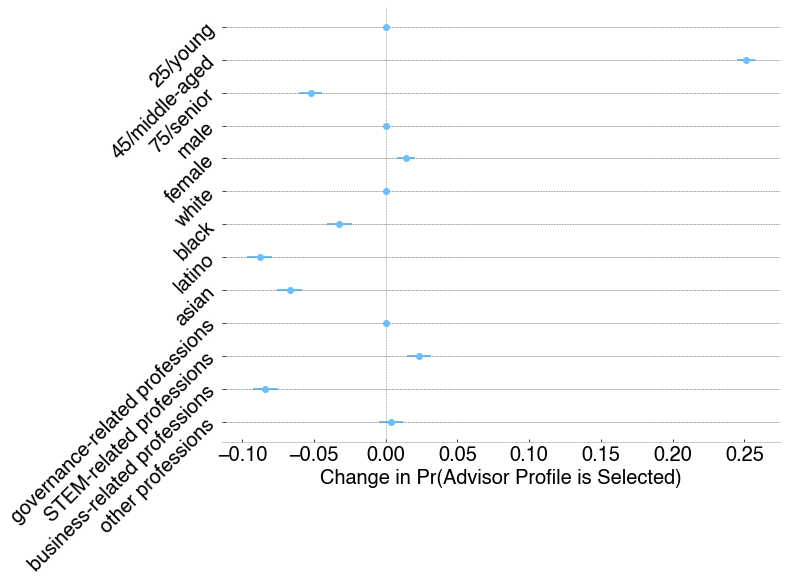

In [32]:
# plot!
fig, axs = plt.subplots(figsize=(10, 8))
axs.set_facecolor('white')
axs.xaxis.grid(False)
axs.axvline(0, linestyle='--', color='grey', lw=0.5)
[plt.axhline(y=i, linestyle='--', color='grey', lw=0.5) for i in [0,1,2,3,4,5,6,7,8,9,10,11,12]]
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.spines['left'].set_visible(False)
plt.errorbar(values, names, xerr=err_values, fmt='o', color='#6abffc')
plt.xticks(fontsize=20, color='black')
plt.yticks(fontsize=20, color='black',  rotation=45)
plt.xlabel('Change in Pr(Advisor Profile is Selected)', fontsize=20, color='black')

In [24]:
# define dict to contain all the marginal effects in each attribute
range_per_attribute = dict()

# compute all the marginal effects in each attribute
for key, coeff in reg.params.items():
    sk =  key.split('_')
    feature = sk[0]
    if len(sk) == 1:
        feature = key
    if feature not in range_per_attribute:
        range_per_attribute[feature] = list()
        
    range_per_attribute[feature].append(coeff)
    
# add marginal effects of reference level = 0
range_per_attribute['age'].append(0) # age = 25
range_per_attribute['gender'].append(0) # gender = male
range_per_attribute['race'].append(0) # race = white
range_per_attribute['profession'].append(0) # profession = gov related

In [25]:
# importance of an attribute is defined as the range of marginal effects within each attribute
# where range is max(x) - min(x)
importance_per_attribute = {
    k: max(v) - min(v) for k, v in range_per_attribute.items()
}

# relative importance per attribute is normalized importance = dividing by sum of importance for all attributes
total_attribute_importance = sum(importance_per_attribute.values())
relative_importance_per_attribute = {
    k: 100 * round(v/total_attribute_importance, 3) for k, v in importance_per_attribute.items()
}


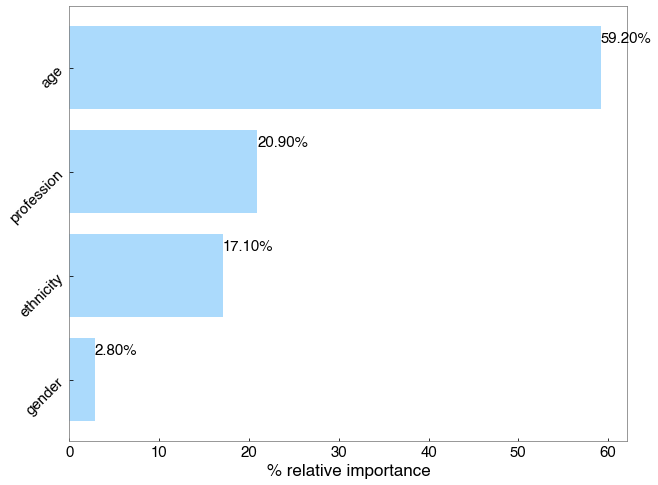

In [26]:
# create dataframe to plot the relative importance of each attribute
alt_data = pd.DataFrame(list(relative_importance_per_attribute.items()),columns=['attr', 'relative_importance']
                       ).sort_values(by='relative_importance', ascending=True)

# plot the relative importance of each attribute
f, ax = plt.subplots(figsize=(10, 8))

# arrange from attribute with highest importance to attribute with lowest importance
xbar = np.arange(len(alt_data['attr']))

# define bar plots
plt.barh(xbar, alt_data['relative_importance'],color='#abdafc')

# format data labels
for i, v in enumerate(alt_data['relative_importance']):
    ax.text(v , i + .25, '{:.2f}%'.format(v), fontsize=15)

# x axis label
plt.xlabel('% relative importance', fontsize=17)

# set y ticks
plt.yticks(xbar, alt_data['attr'])
labels = [item.get_text() for item in ax.get_yticklabels()]
labels[1] = 'ethnicity' # using ethnicity instead of race to ensure consistency
ax.set_yticklabels(labels, fontsize=15, rotation=45)

# some style choices
for spine in ax.spines:
    ax.spines[spine].set_color('grey')
ax.set_facecolor('white')
ax.tick_params(labelsize=15)
ax.grid(False)

# show plot
plt.show()

### 2. Reporting AUROC - leave-one-subject-out cross validation

In [27]:
# form dataset including x, y, and session_id (to identify subjects given each subject has a unique session id)
data = dataset_conjoint[['session_id','age', 'gender', 'race', 'profession_category', 'selected']]

In [28]:
# dummy encode values except for session_id and y value selected
data = pd.get_dummies(data, columns=[c for c in data.columns if c != 'session_id' and c!='selected'], drop_first=True)

In [29]:
# create list of unique session_ids
IDlist = list(data['session_id'])
IDlist_unique = unique(IDlist)
data['session_id'] = data['session_id'].apply(str)
y_pred_arr = []
y_test_arr = []

In [30]:
# validate using leave-one-subject-out cross validation
for i in IDlist_unique:
    loso_cv(i, data, y_test_arr, y_pred_arr)
    idt = str(i)

Optimization terminated successfully.
         Current function value: 0.632824
         Iterations 5
training # 304SM51WA34Z8NSIG9O4L67H4DVBS4 completed
prediction completed
Optimization terminated successfully.
         Current function value: 0.632911
         Iterations 5
training # 304SM51WA34Z8NSIG9O4L67H5OCBS8 completed
prediction completed
Optimization terminated successfully.
         Current function value: 0.633023
         Iterations 5
training # 304SM51WA34Z8NSIG9O4L67H5OZBSV completed
prediction completed
Optimization terminated successfully.
         Current function value: 0.632773
         Iterations 5
training # 308Q0PEVB8DRQGAPDDGUQY648WC9IL completed
prediction completed
Optimization terminated successfully.
         Current function value: 0.633074
         Iterations 5
training # 308XBLVESI4N78S51KOZVW2LJMKBRB completed
prediction completed
Optimization terminated successfully.
         Current function value: 0.632879
         Iterations 5
training # 30BUDKLTXDVW

In [31]:
# get auroc using leave-one-subject-our cross validation
auroc_crossval = roc_auc_score(y_test_arr, y_pred_arr)  
print("The AUROC after leave-one-subject-out cross-validation is ", auroc_crossval)

The AUROC after leave-one-subject-out cross-validation is  0.6764492857017359
